In [97]:
import pandas as pd

import numpy as np

import pickle

from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

from optimum.bettertransformer import BetterTransformer

import torch

import progressbar

import csv

import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)

import matplotlib.pyplot as plt

In [26]:
# Abrindo o objeto dataframe
with open(r'df-novos400-tokenizado.pickle', 'rb') as pickledfile:
    df = pickle.load(pickledfile)

In [27]:
df.tail()

,index,Assunto,Texto original,Texto semi-tratado,Existe,Texto tratado,Tokenizadas,id_categ,n_tokens,n_uniq_tokens
1995,6711,Direito do Trabalho,\nEmenta: ACIDENTE DO TRABALHO - PROVA TESTEMU...,ACIDENTE DO TRABALHO - PROVA TESTEMUNHAL - OIT...,0,ACIDENTE DO TRABALHO - PROVA TESTEMUNHAL - OIT...,"[101, 11247, 6392, 12547, 16017, 15040, 267, 5...",395,359,220
1996,6712,Direito do Trabalho,\nEmenta: ACIDENTE DO TRABALHO - EXTINÇÃO DO F...,ACIDENTE DO TRABALHO - EXTINÇÃO DO FEITO - DES...,0,ACIDENTE DO TRABALHO - EXTINÇÃO DO FEITO - DES...,"[101, 11247, 6392, 12547, 16017, 15040, 267, 5...",396,194,136
1997,6713,Direito do Trabalho,\nEmenta: ACIDENTE DO TRABALHO - AUXILIO-ACIDE...,ACIDENTE DO TRABALHO - AUXILIO-ACIDENTE - DOEN...,0,ACIDENTE DO TRABALHO - AUXILIO-ACIDENTE - DOEN...,"[101, 11247, 6392, 12547, 16017, 15040, 267, 5...",397,250,149
1998,6714,Direito do Trabalho,\n\n\t\t\t\t\t\t\t\t\t\t\t\t\tEmenta:\n\t\t\t\...,"RECORRENTE Juízo ""Ex-Officio"" APELANTE Institu...",0,"RECORRENTE Juízo ""Ex-Officio"" APELANTE Institu...","[101, 257, 5476, 8718, 7286, 8427, 22309, 1613...",398,62,53
1999,6715,Direito do Trabalho,\nEmenta: ACIDENTE DO TRABALHO - AUXILIO-ACIDE...,ACIDENTE DO TRABALHO - AUXILIO-ACIDENTE - DOEN...,0,ACIDENTE DO TRABALHO - AUXILIO-ACIDENTE - DOEN...,"[101, 11247, 6392, 12547, 16017, 15040, 267, 5...",399,328,170


In [10]:
# Abrindo o name mapping
with open(r'rfbow-mapping.pickle', 'rb') as pickledfile:
    le_name_mapping = pickle.load(pickledfile)

<h2>Modelo Random Forest - Bag of Words</h2>

In [28]:
# Abrindo o bag-of-words
with open(r'bow-novos400.pickle', 'rb') as pickledfile:
    x = pickle.load(pickledfile)

In [29]:
# Abrindo o modelo final
with open(r'random-forest-bow-final.pickle', 'rb') as pickledfile:
    model = pickle.load(pickledfile)

In [60]:
result = model.predict(x)

In [61]:
result_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(i)] for i in result])

In [62]:
cm = confusion_matrix(np.array(df['Assunto']), result_label, labels = list(le_name_mapping.keys()))

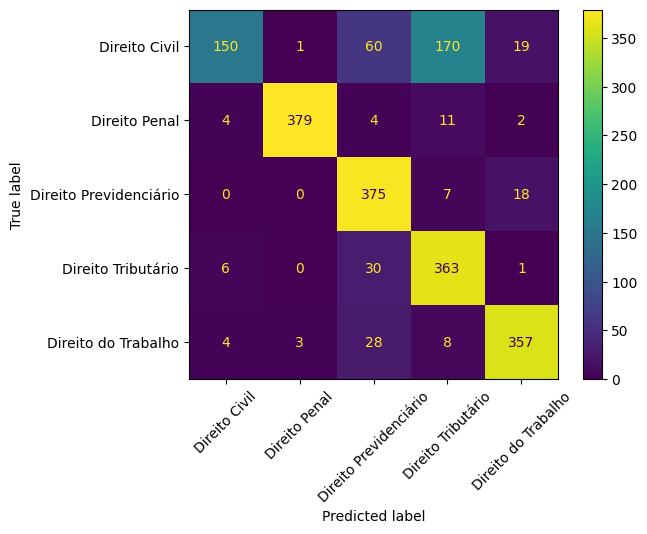

In [63]:
disp = ConfusionMatrixDisplay(cm, display_labels = list(le_name_mapping.keys()))
disp.plot(xticks_rotation=45.0)
plt.show()

In [64]:
cm.diagonal()/cm.sum(axis=1)

array([0.375 , 0.9475, 0.9375, 0.9075, 0.8925])

<h2>Modelo Random Forest - TF-IDF</h2>

In [55]:
# Abrindo o tf-idf
with open(r'tfidf-novos.pickle', 'rb') as pickledfile:
    x2 = pickle.load(pickledfile)

In [56]:
# Abrindo o modelo final
with open(r'random-forest-tfidf-final.pickle', 'rb') as pickledfile:
    model2 = pickle.load(pickledfile)

In [66]:
result2 = model2.predict(x2)

In [67]:
result2_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(i)] for i in result2])

In [68]:
cm2 = confusion_matrix(np.array(df['Assunto']), result2_label, labels = list(le_name_mapping.keys()))

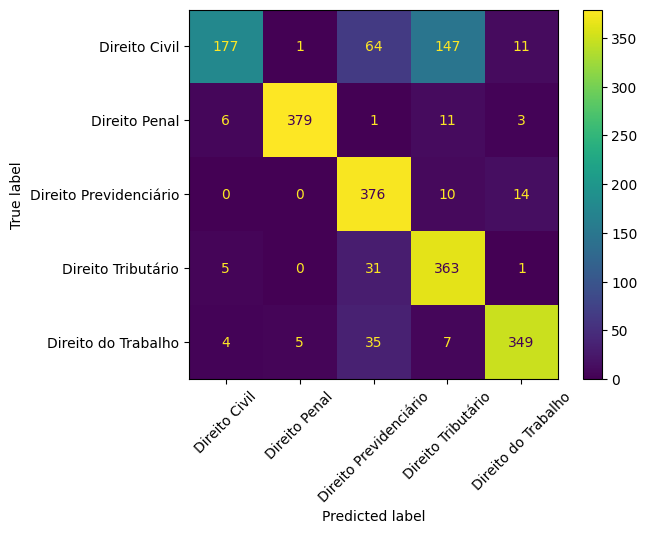

In [69]:
disp2 = ConfusionMatrixDisplay(cm2, display_labels = list(le_name_mapping.keys()))
disp2.plot(xticks_rotation=45.0)
plt.show()

In [70]:
cm2.diagonal()/cm2.sum(axis=1)

array([0.4425, 0.9475, 0.94  , 0.9075, 0.8725])

<h2>Modelo Random Forest - BERT</h2>

In [15]:
bertmodel = BetterTransformer.transform(AutoModel.from_pretrained('neuralmind/bert-large-portuguese-cased'))

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [74]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased')

In [75]:
# Obtendo o último hidden state para o token [CLS]

widgets = [' [',
         progressbar.Timer(),
         '] ',
           progressbar.Bar('*'),' (',
           progressbar.ETA(), ') ',
          ]
bar = progressbar.ProgressBar(maxval = len(df), widgets=widgets).start()

# salvando para CSV, assim caso o computador desligue, o progresso não será perdido
with open(r'embeddings_novos.csv', 'w') as csvfile:
  csvwriter = csv.writer(csvfile, delimiter=';', lineterminator = '\n')
  csvwriter.writerow(['Index', 'Embedding'])

  with torch.no_grad():
    for i in range(len(df)):
      embeddings = bertmodel(tokenizer.encode(df['Texto tratado'][i], return_tensors='pt', max_length=512, truncation=True))['last_hidden_state'][0][0].cpu().detach().numpy()
      # salvando para CSV, assim caso o computador desligue, o progresso não será perdido
      csvwriter.writerow([i, embeddings])
      bar.update(i+1)

In [76]:
embeddings = pd.read_csv(r'embeddings_novos.csv', sep=';')

In [77]:
embeddings.index = embeddings['Index'].values
embeddings.drop('Index', axis=1, inplace=True)

In [78]:
for i in range(len(embeddings)):
    row = embeddings['Embedding'][i].replace('[', '').replace(']', '').split(' ')
    while '' in row:
        row.remove('')
    row = np.array([float(elem) for elem in row])
    embeddings.loc[i, 'Embedding'] = row

In [81]:
# Abrindo o modelo final
with open(r'random-forest-bert-final.pickle', 'rb') as pickledfile:
    model3 = pickle.load(pickledfile)

In [82]:
result3 = model3.predict(embeddings['Embedding'].to_list())

In [83]:
result3_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(i)] for i in result3])

In [84]:
cm3 = confusion_matrix(np.array(df['Assunto']), result3_label, labels = list(le_name_mapping.keys()))

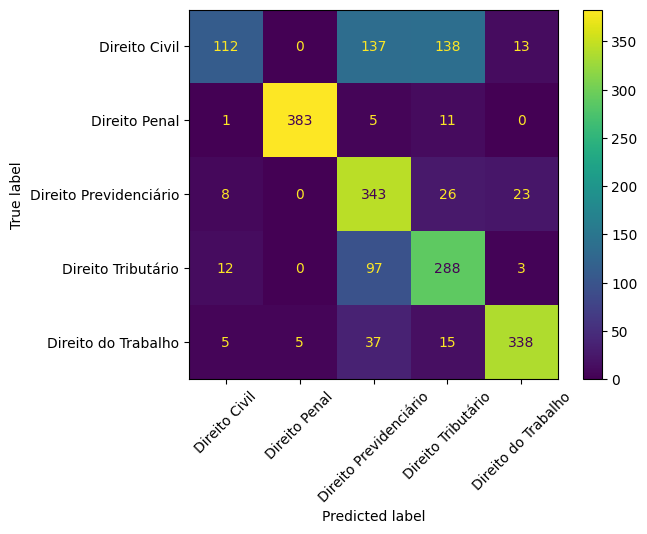

In [85]:
disp3 = ConfusionMatrixDisplay(cm3, display_labels = list(le_name_mapping.keys()))
disp3.plot(xticks_rotation=45.0)
plt.show()

In [86]:
cm3.diagonal()/cm3.sum(axis=1)

array([0.28  , 0.9575, 0.8575, 0.72  , 0.845 ])

<h2>Modelo BERT</h2>

In [89]:
model4 = AutoModelForSequenceClassification.from_pretrained("lucasbalponti/total")

In [98]:
pipe = TextClassificationPipeline(model=model4, tokenizer=tokenizer)

In [152]:
result4 = [pipe(df['Texto tratado'][i], 
                **{'max_length': 512, 'truncation':'only_first'},
                top_k=None) for i in range(len(df))]

In [160]:
result4n = [max(row, key = lambda i: i['score'])['label'][-1] for row in result4]

In [161]:
result4_label = np.array([list(le_name_mapping.keys())[list(le_name_mapping.values()).index(int(i))] for i in result4n])

In [162]:
cm4 = confusion_matrix(np.array(df['Assunto']), result4_label, labels = list(le_name_mapping.keys()))

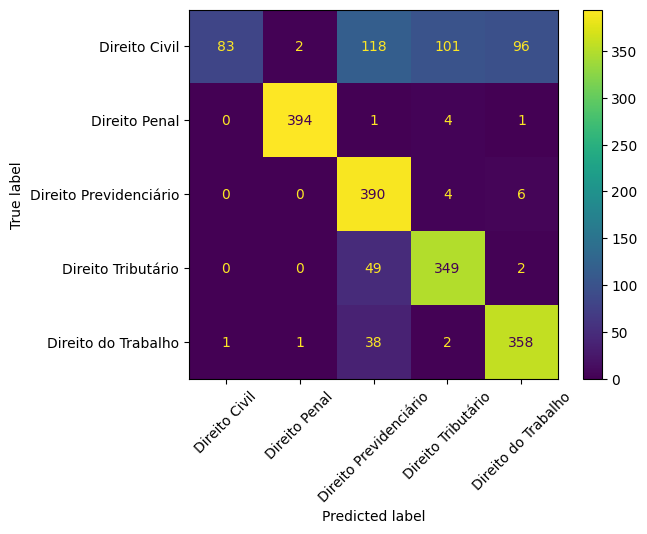

In [163]:
disp4 = ConfusionMatrixDisplay(cm4, display_labels = list(le_name_mapping.keys()))
disp4.plot(xticks_rotation=45.0)
plt.show()

In [164]:
cm3.diagonal()/cm3.sum(axis=1)

array([0.28  , 0.9575, 0.8575, 0.72  , 0.845 ])

In [168]:
df['result_bow'] = list(result_label)
df['result_tfidf'] = list(result2_label)
df['result-bert-rf'] = list(result3_label)
df['result-bert'] = list(result4_label)
df['logits-bert'] = list(result4)

In [169]:
df.head()

,index,Assunto,Texto original,Texto semi-tratado,Existe,Texto tratado,Tokenizadas,id_categ,n_tokens,n_uniq_tokens,result_bow,result_tfidf,result-bert-rf,result-bert,logits-bert
0,0,Direito Tributário,\n\n\t\t\t\t\t\t\t\t\t\t\t\t\tEmenta:\n\t\t\t\...,EMBARGOS DE DECLARAÇÃO – Alegação de omissão e...,0,EMBARGOS DE DECLARAÇÃO – Alegação de omissão e...,"[101, 192, 17166, 6765, 17807, 22308, 10836, 1...",0,99,82,Direito Previdenciário,Direito Previdenciário,Direito Previdenciário,Direito Previdenciário,"[{'label': 'LABEL_2', 'score': 0.9987806677818..."
1,1,Direito Tributário,\nEmenta: APELAÇÃO – Execução Fiscal – Multa...,APELAÇÃO – Execução Fiscal – Multa Administrat...,0,APELAÇÃO – Execução Fiscal – Multa Administrat...,"[101, 12127, 9008, 22301, 22402, 16484, 1379, ...",1,217,149,Direito Tributário,Direito Tributário,Direito Tributário,Direito Tributário,"[{'label': 'LABEL_3', 'score': 0.9997418522834..."
2,2,Direito Tributário,\nEmenta: EMBARGOS DE DECLARAÇÃO\r\nAlegação d...,EMBARGOS DE DECLARAÇÃO Alegação de omissão – I...,0,EMBARGOS DE DECLARAÇÃO Alegação de omissão – I...,"[101, 192, 17166, 6765, 17807, 22308, 10836, 1...",2,123,90,Direito Tributário,Direito Tributário,Direito Tributário,Direito Previdenciário,"[{'label': 'LABEL_2', 'score': 0.7974733114242..."
3,3,Direito Tributário,\nEmenta: APELAÇÃO CÍVEL – Mandado de Seguran...,APELAÇÃO CÍVEL – Mandado de Segurança – ITBI –...,0,APELAÇÃO CÍVEL – Mandado de Segurança – ITBI –...,"[101, 12127, 9008, 22301, 22402, 16484, 187, 2...",3,167,129,Direito Tributário,Direito Tributário,Direito Previdenciário,Direito Tributário,"[{'label': 'LABEL_3', 'score': 0.9880988001823..."
4,4,Direito Tributário,\nEmenta: AGRAVO DE INSTRUMENTO – Execução fi...,AGRAVO DE INSTRUMENTO – Execução fiscal – Exce...,0,AGRAVO DE INSTRUMENTO – Execução fiscal – Exce...,"[101, 177, 22328, 5650, 22339, 22317, 10836, 1...",4,143,114,Direito Tributário,Direito Tributário,Direito Tributário,Direito Tributário,"[{'label': 'LABEL_3', 'score': 0.9996102452278..."


In [170]:
# Salvando o objeto dataframe
with open(r'df-novos400-result.pickle', 'wb') as pickledfile:
    pickle.dump(df, pickledfile, protocol=pickle.HIGHEST_PROTOCOL)